In [133]:
import pandas as pd
import numpy as np
import os
from tqdm.auto import tqdm, trange
import time
import matplotlib.pyplot as plt
import utils
import json
import seaborn as sns

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchio as tio
import monai

import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import LeaveOneOut, train_test_split

from datetime import datetime

# from google.colab import drive

torch.manual_seed(7)
torch.set_grad_enabled(False)
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
dfs = {}

for algorithm in ["logreg", "svm", "knn", "mlp", "gauss"]:
    dfs[algorithm] = utils.printTableUniMulti(
        f"../study/stats/results-{algorithm}-loo-filter-Uni-Multi.json",
        score="acc",
        skip_uni=["fechner_corr", "gini_index", "information_gain", "pearson_corr", "su_measure"],
        skip_multi=["CMIM", "IWFS", "JMI", "MIM"],
        add_uni={
            "Man": f"../study/stats/results-{algorithm}-loo-filter-Man-Multi.json",
            "ManKru": f"../study/stats/results-{algorithm}-loo-filter-ManKru-Multi.json"
        }
    )
    print()

                    	CFR 	CIFE 	DCSF 	ICAP 	MRI 	MRMR 	
     f_ratio_measure	0.7143	0.6429	0.7662	0.8117	0.6429	0.7857	
        kendall_corr	0.7403	0.5000	0.7143	0.5000	0.6429	0.5000	
     reliefF_measure	0.5000	0.7662	0.5000	0.6429	0.5000	0.5000	
       spearman_corr	0.5000	0.5000	0.6688	0.5714	0.5000	0.5714	
                 Man	0.8117	0.7403	0.6429	0.7143	0.8117	0.6429	
              ManKru	0.6429	0.7403	0.6429	0.7403	0.7403	0.7662	
                    	CFR 	CIFE 	DCSF 	ICAP 	MRI 	MRMR 	
     f_ratio_measure	0.5000	0.5714	0.5000	0.5714	0.5000	0.5000	
        kendall_corr	0.5000	0.5000	0.5000	0.5000	0.5000	0.5000	
     reliefF_measure	0.5000	0.5000	0.5000	0.5714	0.5000	0.5000	
       spearman_corr	0.5000	0.5000	0.5000	0.5000	0.5000	0.5000	
                 Man	0.5000	0.5000	0.5000	0.5000	0.5000	0.5000	
              ManKru	0.5000	0.5000	0.5000	0.5000	0.5000	0.5000	
                    	CFR 	CIFE 	DCSF 	ICAP 	MRI 	MRMR 	
     f_ratio_measure	0.8117	0.5000	0.5974	0.8636	0.6429	0.7143	


<Axes: >

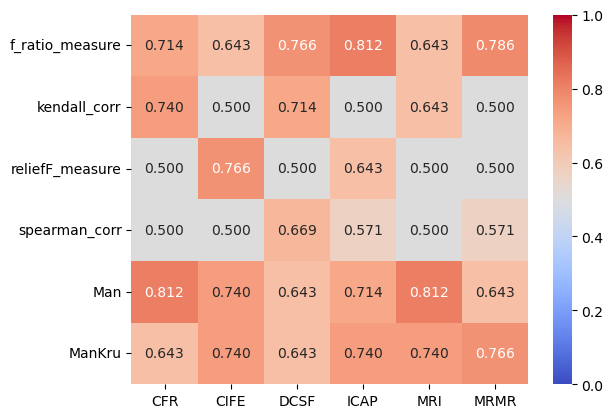

In [28]:
sns.heatmap(dfs["logreg"], annot=True, fmt=".3f", vmin=0, vmax=1, cmap="coolwarm")

In [236]:
study_path = "../study"

info_df = pd.read_csv(f"{study_path}/stats/info.csv").dropna()

subjects = []

for idx, row in info_df.iterrows():
    if "VNSLC" not in row.ID:
        continue
    
    subj_dict = {
        "id": row.ID,
        "resp": row.resp, # Prova cambiando in 0, 0.75, 1
        "age": row.age,
        "sex": row.sex,
        "epilepsy_type": row.epilepsy_type,
        "epilepsy_onset_age": row.epilepsy_onset_age,
        "therapy_duration": row.therapy_duration,
        "AEDs": row.AEDs,
        "FA": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/dti/{row.ID}_FA.nii.gz"),
        "MD": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/dti/{row.ID}_MD.nii.gz"),
        "AD": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/dti/{row.ID}_AD.nii.gz"),
        "RD": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/dti/{row.ID}_RD.nii.gz"),
        "wFA": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/diamond/{row.ID}_diamond_wFA.nii.gz"),
        "wMD": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/diamond/{row.ID}_diamond_wMD.nii.gz"),
        "wAD": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/diamond/{row.ID}_diamond_wAD.nii.gz"),
        "wRD": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/diamond/{row.ID}_diamond_wRD.nii.gz"),
        "diamond_frac_csf": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/diamond/{row.ID}_diamond_frac_csf.nii.gz"),
        "icvf": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/noddi/{row.ID}_noddi_icvf.nii.gz"),
        "odi": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/noddi/{row.ID}_noddi_odi.nii.gz"),
        "fextra": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/noddi/{row.ID}_noddi_fextra.nii.gz"),
        "fiso": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/noddi/{row.ID}_noddi_fiso.nii.gz"),
        "wfvf": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/mf/{row.ID}_mf_wfvf.nii.gz"),
        "fvf_tot": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/mf/{row.ID}_mf_fvf_tot.nii.gz"),
        "mf_frac_csf": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/mf/{row.ID}_mf_frac_csf.nii.gz"),
        "WM_mask": tio.LabelMap(f"{study_path}/freesurfer/{row.ID}/dlabel/diff/White-Matter++.bbr.nii.gz"),
        "aparc_aseg": tio.LabelMap(f"{study_path}/freesurfer/{row.ID}/dlabel/diff/aparc+aseg+thalnuc.bbr.nii.gz"),
        "t1": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/registration/{row.ID}_T1_brain_reg.nii.gz"),
        # "tract": tio.ScalarImage(f"{study_path}/freesurfer/{row.ID}/dpath/merged_avg16_syn_bbr.mgz")
    }

    subjects.append(tio.Subject(subj_dict))

In [240]:
subjects[0]["FA"].data

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 

In [202]:
preprocessing_transform = tio.Compose([
    ## Preprocessing ##
    # Spatial
    tio.transforms.ToCanonical(),
    tio.transforms.Resample("FA"),
    tio.transforms.CopyAffine("FA"),
    tio.transforms.EnsureShapeMultiple(8, method="crop"),
    # Voxel Intensity
    tio.transforms.Mask(masking_method="aparc_aseg"),
    # tio.transforms.RescaleIntensity(percentiles=(0.5, 99.5), masking_method="aparc_aseg"),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
])

training_transform = tio.Compose([
    tio.RandomMotion(p=0.2),
    tio.RandomBiasField(p=0.3),
    tio.RandomNoise(p=0.5),
    tio.OneOf({
        tio.RandomAffine(): 0.8,
        tio.RandomElasticDeformation(): 0.2,
    })
])

In [176]:
c = torch.cat([a,b])

In [177]:
c.shape

torch.Size([2, 104, 104, 64])

In [233]:
net = monai.networks.nets.ResNet(
    block="bottleneck",
    layers=[2, 2, 2, 2],
    block_inplanes=[64, 128, 256, 512],
    n_input_channels=1,
    num_classes=1,
).to(device)

In [234]:
test = subjects[2]["FA"].data[np.newaxis].to(device)
net(test)

tensor([[0.8584]], device='cuda:0')

In [197]:
def looPytorch():
  avg_score = []

  for train_val_idx, test_idx in LeaveOneOut().split(info_df):
    train_val = info_df.iloc[train_val_idx, :]
    test = info_df.iloc[test_idx, :]
    for train_idx, val_idx in LeaveOneOut().split(train_val):
      train = train_val.iloc[train_idx, :]
      val = train_val.iloc[val_idx, :]

      print(train_idx)

      # evaluate the model, fo the hyperParameters selection

    # Select the best model and use it for the test
    # test the model, compute the score and add tot the list

  # mean of avg_score
  return np.mean(avg_score)


In [212]:
training_subjects, validation_subjects, testing_subjects = torch.utils.data.random_split(subjects, [0.8, 0.1, 0.1])

training_set = tio.SubjectsDataset(
    training_subjects, transform=tio.Compose([preprocessing_transform, training_transform])
)
validation_set = tio.SubjectsDataset(
    validation_subjects, transform=tio.Compose([preprocessing_transform])
)
testing_set = tio.SubjectsDataset(
    testing_subjects, transform=tio.Compose([preprocessing_transform])
)

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')
print('Test set:', len(testing_set), 'subjects')

Training set: 16 subjects
Validation set: 2 subjects
Test set: 1 subjects


In [9]:
class ModelTrainer():
    class Action(enum.Enum):
        TRAIN = 'Training'
        VALIDATE = 'Validation'

    def __init__(self, train_dataset, val_dataset, model, device, loss_fn, optimizer, batch_size):
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.model = model.to(device)
        self.device = device
        self.loss_fn = loss_fn
        self.optimizer = optimizer

        self.train_loader = DataLoader(
            self.train_dataset,
            batch_size,
            shuffle=True
        )

        self.val_loader = DataLoader(
            self.val_dataset,
            batch_size,
            shuffle=True
        )

        self.epoch_number = 0

    def __prepare_batch(self, batch, device):
        
        for image_type in ['FA', 'MD', 'AD', 'RD', 'wFA', 'wMD', 'wAD', 'wRD', 'diamond_frac_csf', 'icvf', 'odi', 'fextra', 'fiso', 'wfvf', 'fvf_tot', 'mf_frac_csf', 't1']
            batch[image_type][tio.DATA]
        pass

    def __get_probabilities(self,):
        pass

    def __get_loss(self, ):
        pass

    def __runOneEpoch(self, epoch_idx, loader):
        self.is_trining = action == Action.TRAIN
        epoch_losses = []
        times = []
        self.model.train(is_training)
        for batch_idx, batch in enumerate(tqdm(loader)):
            inputs, targets = self.__prepare_batch(batch, self.device)
            self.optimizer.zero_grad()
            with torch.set_grad_enabled(is_training):
                logist = self.model(inputs)
                probabilities = self.__get_probabilities(logist)
                batch_losses = self.__get_loss(probabilities, targets)
                batch_loss = batch_losses.mean()
                if is_training:
                    batch_loss.backward()
                    optimizer.step()
                times.append(time.time())
                epoch_losses.append(batch_loss.item())
        epoch_losses = np.array(epoch_losses)
        print(f'{action.value} mean loss: {epoch_losses.mean():0.3f}')

        return times, epoch_losses


    def train(self, epochs):
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

        EPOCHS = epochs

        best_vloss = 1_000_000

        for epoch in range(EPOCHS):
            print("EPOCH {}".format(self.epoch_number + 1))

            # Set the model to training mode
            self.model.train()
            avg_loss = self.__trainOneEpoch(self.epoch_number, writer)

            # Set the model to validation mode
            running_vloss = 0.0
            self.model.eval()

            with torch.no_grad():
                for i, vdata in enumerate(self.val_loader):
                    # Get the features and the labels
                    features, labels = vdata
                    features = features.to(self.device)
                    labels = labels.to(self.device)

                    voutputs = self.model(features)

                    loss = self.loss_fn(voutputs, labels)
                    running_vloss +=loss

            avg_vloss = running_vloss/(i+1)
            print("LOSS train {} valid {}".format(avg_loss, avg_vloss))

            # Data and report Statistics
            writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    self.epoch_number + 1)
            writer.flush()

            if avg_vloss < best_vloss:
                best_vloss = avg_vloss
                model_path = "model_{}_{}".format(timestamp, self.epoch_number)
                torch.save(self.model.state_dict(), model_path)

            self.epoch_number += 1


Creating my neural network

In [10]:
class NeuralNetwork(nn.Module):
  def __init__(self, in_features: int, hidden_features: int):
    super().__init__()

    self.activation = nn.ReLU()

    self.fc1 = nn.Linear(
        in_features=in_features,
        out_features=hidden_features,
        dtype=torch.float64
    )
    self.fc2 = nn.Linear(
        in_features=hidden_features,
        out_features=1,
        dtype=torch.float64
    )
    self.sigmoid = nn.Sigmoid()

  def forward(self, X):
    X = self.activation(self.fc1(X))
    X = self.fc2(X)
    X = self.sigmoid(X)
    return X

In [11]:
network = NeuralNetwork(X_train.shape[1], 100).to(device)

model_trainer = ModelTrainer(
    DatasetDiffusionMRI(X_train, y_train, device),
    DatasetDiffusionMRI(X_val, y_val, device),
    network,
    device,
    nn.BCELoss(),
    optim.Adam(network.parameters(), lr=1),
    batch_size=4,
)

In [13]:
model_trainer.train(100)

EPOCH 11
	batch 1 loss: 25.0
	batch 2 loss: 25.0
	batch 3 loss: 50.0
LOSS train 33.333333333333336 valid 66.66666666666666
EPOCH 12
	batch 1 loss: 25.0
	batch 2 loss: 50.0
	batch 3 loss: 25.0
LOSS train 33.333333333333336 valid 66.66666666666666
EPOCH 13
	batch 1 loss: 0.0
	batch 2 loss: 50.0
	batch 3 loss: 50.0
LOSS train 33.333333333333336 valid 66.66666666666666
EPOCH 14
	batch 1 loss: 25.0
	batch 2 loss: 50.0
	batch 3 loss: 25.0
LOSS train 33.333333333333336 valid 66.66666666666666
EPOCH 15
	batch 1 loss: 50.0
	batch 2 loss: 25.0
	batch 3 loss: 25.0
LOSS train 33.333333333333336 valid 66.66666666666666
EPOCH 16
	batch 1 loss: 25.0
	batch 2 loss: 75.0
	batch 3 loss: 1.436309697269979e-35
LOSS train 33.333333333333336 valid 66.66666666666666
EPOCH 17
	batch 1 loss: 50.0
	batch 2 loss: 25.0
	batch 3 loss: 25.0
LOSS train 33.333333333333336 valid 66.66666666666666
EPOCH 18
	batch 1 loss: 50.0
	batch 2 loss: 25.0
	batch 3 loss: 25.0
LOSS train 33.333333333333336 valid 66.66666666666666


KeyboardInterrupt: 

In [ ]:
X_train.shape

In [ ]:
target_loss = 1e-4

def optimize_model():
  optimizer = torch.optim.Adam(params = model.parameters(), lr=1e-3)

  while loss > target_loss:
    optimizer.zero_grad()
    outpur = model()